<a href="https://colab.research.google.com/github/amitvasz/CSE676/blob/master/Project2_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('gdrive/My Drive/traffic')  #change dir



In [0]:
# !mkdir train  #create a directory named train/
# !mkdir test  #create a directory named test/

In [0]:
#Reference and idea for project from: https://towardsdatascience.com/traffic-sign-detection-using-convolutional-neural-network-660fb32fe90e
# https://medium.com/@gruby/convolutional-neural-network-for-traffic-sign-classification-carnd-e46e95453899

In [0]:
os.getcwd()


In [3]:
#%tensorflow_version 2.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape

Using TensorFlow backend.


In [0]:
import numpy as np
from math import sqrt, ceil
import pickle
import matplotlib.pyplot as plt


In [0]:
# Defining list with numbers for the files' datasets to load from
n = [1,2,3,4]


In [0]:
# Now lets define a list with preprocessed methods for datasets.
m = ['RGB + /255 + Mean', 'RGB + /255 + Mean + STD', 'LHE + /255 + Mean', 'LHE + /255 + Mean + STD']

# Defining dictionary for saving datasets in
data = {}

# We have total of 43 traffic sign labels so the total number of classes will be 43.
# Going through all of the four datasets' files.
for i in n:
    # Opening file for reading in binary mode
    with open('/content/gdrive/My Drive/traffic/train/data' + str(i) + '.pickle', 'rb') as f:
        data[i] = pickle.load(f, encoding='latin1')  # dictionary type

    # Preparing y_train and y_validation for using in Keras
    data[i]['y_train'] = to_categorical(data[i]['y_train'], num_classes=43)
    data[i]['y_validation'] = to_categorical(data[i]['y_validation'], num_classes=43)

    # Making channels come at the end
    data[i]['x_train'] = data[i]['x_train'].transpose(0, 2, 3, 1)
    data[i]['x_validation'] = data[i]['x_validation'].transpose(0, 2, 3, 1)
    data[i]['x_test'] = data[i]['x_test'].transpose(0, 2, 3, 1)

In [0]:
# #Load original data from data0.pickle
# # Opening file for reading in binary mode
# i=0
# with open('/content/gdrive/My Drive/traffic/train/data' + str(i) + '.pickle', 'rb') as f:
#     data[i] = pickle.load(f, encoding='latin1')  # dictionary type

# # Preparing y_train and y_validation for using in Keras
# data[i]['y_train'] = to_categorical(data[i]['y_train'], num_classes=43)
# data[i]['y_validation'] = to_categorical(data[i]['y_validation'], num_classes=43)

# # Making channels come at the end
# data[i]['x_train'] = data[i]['x_train'].transpose(0, 2, 3, 1)
# data[i]['x_validation'] = data[i]['x_validation'].transpose(0, 2, 3, 1)
# data[i]['x_test'] = data[i]['x_test'].transpose(0, 2, 3, 1)

In [11]:
# # Showing sample pickle0 loaded dataset from the files
# # All the dimensions are the same as, though the data has been manipulated, the data size is still the same
# ii = 0  # index of methods' name
# i=0
# print('data' + str(i) + '.pickle ->', m[ii])
# for k, j in data[i].items():
#     if k == 'labels':
#         print(k + ':', len(j))
#     else: 
#         print(k + ':', j.shape)
# print()
# ii += 1

data0.pickle -> RGB + /255 + Mean
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
x_validation: (4410, 32, 32, 3)
y_validation: (4410, 43)
x_test: (12630, 32, 32, 3)
y_test: (12630,)
labels: 43



In [0]:
# Function for converting a given set of images into a grid format.
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height,grid_width = H * grid_size + 1 * (grid_size - 1), W * grid_size + 1 * (grid_size - 1) 
    grid = np.zeros((grid_height, grid_width, C)) + 255
    y0, y1 = 0, H
    next_idx = 0
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


(49, 32, 32, 3)


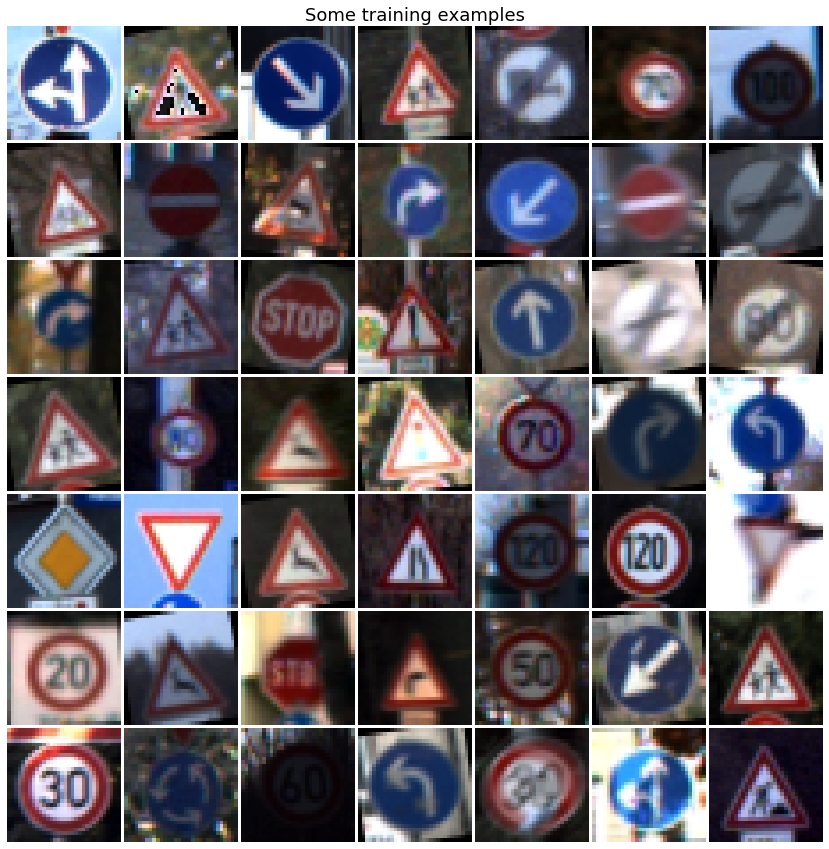

In [12]:

%matplotlib inline


# Now lets visualize and save some examples of training data
some_examples = data[0]['x_train'][:49, :, :, :]
print(some_examples.shape)  # (49, 32, 32, 3)

# Plotting
fig = plt.figure()
grid = convert_to_grid(some_examples)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some training examples', fontsize=18)
plt.show()
plt.close()

# Saving plot
fig.savefig('training_examples.png')
plt.close()

In [13]:
# Load datasets for plotting an original sign, and its modified form from each of the datasets. 
# Loading original RGB Traffic Sign dataset with just the basic shuffling and transposing operations done, without doing 
# any more processing.

%matplotlib inline

with open('/content/gdrive/My Drive/traffic/train/data0.pickle', 'rb') as f:
        data0 = pickle.load(f, encoding='latin1')  # dictionary type

# Making the channels come at the end
data0['x_train'] = data0['x_train'].transpose(0, 2, 3, 1)

# Getting an example from the loaded dataset
example0 = data0['x_train'][2, :, :, :]
print(example0.shape)  # (32, 32, 3)



# Defining dictionary for saving the four examples in
example = {}

# Examples with 3-channeled images RGB images
example[1] = data[1]['x_train'][2, :, :, :]
example[2] = data[2]['x_train'][2, :, :, :]
print(example[1].shape, example[2].shape)  # (32, 32, 3) (32, 32, 3)

# Examples with 1-channeled images grayscale images
example[3] = data[3]['x_train'][2, :, :, 0]
example[4] = data[4]['x_train'][2, :, :, 0]
print(example[3].shape, example[4].shape)  # (32, 32) (32, 32)





(32, 32, 3)
(32, 32, 3) (32, 32, 3)
(32, 32) (32, 32)


In [14]:
# Getting labels' names from the csv file.
# Defining list for saving labels in order from 0 to 42.
labels = []

# Reading 'csv' file and getting labels
r = pd.read_csv('/content/gdrive/My Drive/traffic/train/label_names.csv')
# Going through all names
for name in r['SignName']:
    # Adding from every row second column with name of the label
    labels.append(name)
print(labels)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


In [0]:
# # Load sign names file
# sign_names1 = pd.read_csv('/content/gdrive/My Drive/traffic/train/label_names.csv')
# sign_names1.set_index("ClassId")

# sign_names1.head(n=3)

([], <a list of 0 Text yticklabel objects>)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


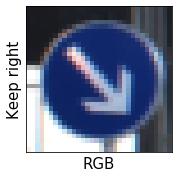

In [15]:
# Plotting an example of an original traffic sign from data0.pickle
plt.rcParams['figure.figsize'] = (12.0, 12.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure()

# Plotting original example
plt.subplot(2, 4, 1)  # rows, columns, current index of the plot
plt.imshow(example0)
plt.xlabel('RGB', fontsize=15)
plt.ylabel(labels[np.argmax(data[2]['y_train'][2])], fontsize=15)
plt.xticks([])
plt.yticks([])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


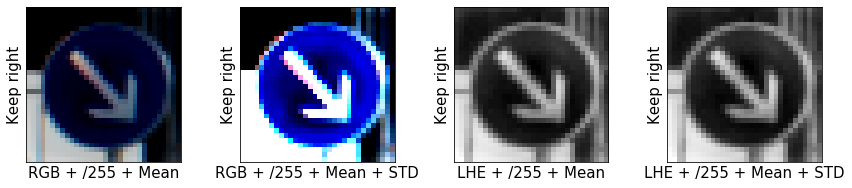

In [23]:
# Plotting examples of the above displayed traffic sign, but preprocessed in four different ways.
# Going through all of the four examples
# Lets set the index for the plots and index for getting the method's name
k = 5  
ii = 0 
for i in n:
    plt.subplot(2, 4, k)  # rows, columns, current index of the plot
    if i == 3 or i == 4:
        plt.imshow(example[i], cmap='gray')
    else:
        plt.imshow(example[i])
    plt.xlabel(m[ii], fontsize=15)
    plt.ylabel(labels[np.argmax(data[2]['y_train'][2])], fontsize=15)
    plt.xticks([])
    plt.yticks([])
    k += 1
    ii += 1

# Adjusting height between subplots
plt.subplots_adjust(hspace=0)
plt.tight_layout()

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('one_ts_from_different_datasets.png')
plt.close()

In [24]:
# Now lets create a sample CNN model for the classification of RGB images, using Relu and Softmax activations, 
# Max Pooling layers, and lets use Adam optimizer for classifications of images.
# I created this sample model for testing with different hyper-parameters and then adopted the best out of them. 
# I read extensively about the LeNet architecture from http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
# I adapted the LeNet architecture from: https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

model = Sequential()

model.add(Conv2D(32, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(64, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Now lets train the sample model on a single RGB dataset by experimenting with different hyper parameters.
# These parameters are not ideal, and the results are not good, after adopting better parameters,
# I later on implemented the models with the optimal parameters.

annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** (x + epochs))
epochs = 20

h = model.fit(data[2]['x_train'][:100], data[2]['y_train'][:100],
              batch_size=5, epochs = epochs,
              validation_data = (data[2]['x_validation'], data[2]['y_validation']),
              callbacks=[annealer], verbose=1)

print()
print('Epochs={0:d}, Train accuracy={1:.5f}, \
      Validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['acc']), max(h.history['val_acc'])))

Train on 100 samples, validate on 4410 samples
Epoch 1/20
100/100 [==============================] - 2s 18ms/step - loss: 2.7568 - acc: 0.2600 - val_loss: 4.5744 - val_acc: 0.0488
Epoch 2/20
100/100 [==============================] - 2s 17ms/step - loss: 2.5855 - acc: 0.3000 - val_loss: 4.7660 - val_acc: 0.0460
Epoch 3/20
100/100 [==============================] - 2s 17ms/step - loss: 2.4600 - acc: 0.3300 - val_loss: 5.0083 - val_acc: 0.0431
Epoch 4/20
100/100 [==============================] - 2s 17ms/step - loss: 2.3710 - acc: 0.3600 - val_loss: 5.1998 - val_acc: 0.0481
Epoch 5/20
100/100 [==============================] - 2s 17ms/step - loss: 2.2812 - acc: 0.4000 - val_loss: 5.3822 - val_acc: 0.0488
Epoch 6/20
100/100 [==============================] - 2s 18ms/step - loss: 2.1903 - acc: 0.4400 - val_loss: 5.5024 - val_acc: 0.0515
Epoch 7/20
100/100 [==============================] - 2s 17ms/step - loss: 2.1136 - acc: 0.4800 - val_loss: 5.6253 - val_acc: 0.0488
Epoch 8/20
100/100 [==

In [0]:
# It can be seen that the training accuracy is okay but the validation accuracy is even worse, so we after experimenting
# with different hyper parameters, we get the ideal values and use it in training the entire datasets.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


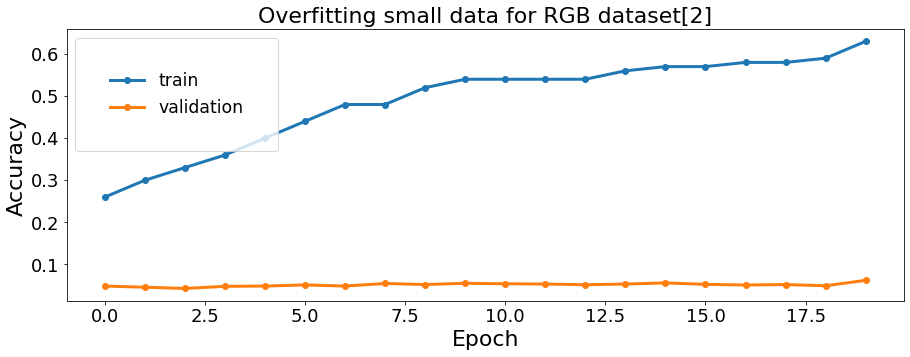

In [29]:
#Lets plot the graph for overfitting small data for RGB dataset over each epoch

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

fig = plt.figure()

plt.plot(h.history['acc'], '-o', linewidth=3.0)
plt.plot(h.history['val_acc'], '-o', linewidth=3.0)
plt.title('Overfitting small data for RGB dataset[2]', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

# Saving the plot
fig.savefig('Overfitting_dataset_2.png')
plt.close()

In [0]:
# Defining dictionary for storing the models.
model = {}

# Building and compiling the model.
# We have a different model for RGB dataset and a different one for grayscale as the number of channels used by them 
# are 3 and 1 respectively.
for i in n:
    model[i] = Sequential()
    if i == 3 or i == 4:
        model[i].add(Conv2D(32, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 1)))
    else:
        model[i].add(Conv2D(32, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
        
    model[i].add(MaxPool2D(pool_size=2))

    model[i].add(Conv2D(64, kernel_size=7, padding='same', activation='relu'))
    model[i].add(MaxPool2D(pool_size=2))

    model[i].add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    model[i].add(MaxPool2D(pool_size=2))

    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))

    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Now lets train our model with data from the image datasets with the ideal hyper parameters that I achieved 
# after experimenting with multiple configurations.
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 20

# Defining dictionary for saving history results
h = {}

for i in n:
    h[i] = model[i].fit(data[i]['x_train'], data[i]['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data[i]['x_validation'], data[i]['y_validation']),
                        callbacks=[annealer], verbose=1)
    
    print('Model trained on dataset{0}.pickle, epochs={1:d}, training accuracy={2:.5f}, \
          validation accuracy={3:.5f}'.format(i, epochs, max(h[i].history['acc']), max(h[i].history['val_acc'])))

Train on 86989 samples, validate on 4410 samples
Epoch 1/20
86989/86989 [==============================] - 95s 1ms/step - loss: 0.5937 - acc: 0.8242 - val_loss: 0.6880 - val_acc: 0.8363
Epoch 2/20
86989/86989 [==============================] - 95s 1ms/step - loss: 0.1077 - acc: 0.9680 - val_loss: 1.0400 - val_acc: 0.8243
Epoch 3/20
86989/86989 [==============================] - 95s 1ms/step - loss: 0.0727 - acc: 0.9795 - val_loss: 0.7508 - val_acc: 0.8732
Epoch 4/20
86989/86989 [==============================] - 94s 1ms/step - loss: 0.0583 - acc: 0.9846 - val_loss: 0.8622 - val_acc: 0.8748
Epoch 5/20
86989/86989 [==============================] - 95s 1ms/step - loss: 0.0554 - acc: 0.9860 - val_loss: 1.3182 - val_acc: 0.8451
Epoch 6/20
86989/86989 [==============================] - 95s 1ms/step - loss: 0.0457 - acc: 0.9890 - val_loss: 1.0991 - val_acc: 0.8689
Epoch 7/20
86989/86989 [==============================] - 95s 1ms/step - loss: 0.0436 - acc: 0.9902 - val_loss: 1.4393 - val_acc:

In [32]:
print(h[1].history['acc'])

[0.8241731770898747, 0.9679614682882439, 0.9795491396157752, 0.9845727629929006, 0.9860097262014605, 0.9889986096752652, 0.9901596759477816, 0.9919415103263959, 0.9923323643191242, 0.9933669778292874, 0.9938497974673636, 0.9945510355131407, 0.9953327434985973, 0.9960454772500431, 0.9966547496504725, 0.996620262533467, 0.9973789791075867, 0.9972410306395649, 0.997792824511652, 0.9981951742100488]


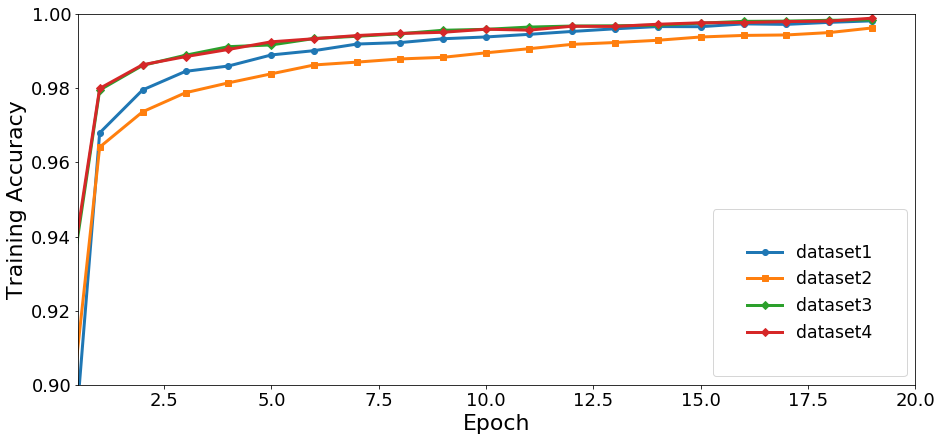

In [33]:
#Now lets plot the graph for accuracy of the training and validation data of all the four datasets.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'Times New Roman'
fig = plt.figure()

# Plotting history of training accuracy
plt.subplot(2, 1, 1)
plt.plot(h[1].history['acc'], '-o', linewidth=3.0)
plt.plot(h[2].history['acc'], '-s', linewidth=3.0)
plt.plot(h[3].history['acc'], '-D', linewidth=3.0)
plt.plot(h[4].history['acc'], '-D', linewidth=3.0)
plt.xlabel('Epoch', fontsize=22, fontname='Times New Roman')
plt.ylabel('Training Accuracy', fontsize=22, fontname='Times New Roman')
plt.legend(['dataset1', 'dataset2', 'dataset3', 'dataset4'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.yscale('linear') 
plt.ylim(0.9, 1.0)
plt.xlim(0.5, 20)
plt.tick_params(labelsize=18)
# plt.title('Accuracy for different datasets', fontsize=20)



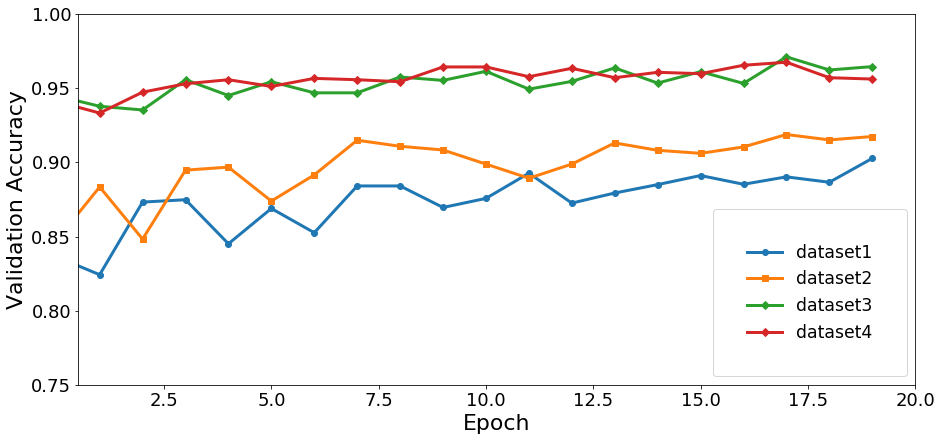

In [34]:
# Plotting history of validation accuracy
plt.subplot(2, 1, 2)
# plt.gca().set_title('Validation accuracy')
plt.plot(h[1].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[2].history['val_acc'], '-s', linewidth=3.0)
plt.plot(h[3].history['val_acc'], '-D', linewidth=3.0)
plt.plot(h[4].history['val_acc'], '-D', linewidth=3.0)
plt.xlabel('Epoch', fontsize=22, fontname='Times New Roman')
plt.ylabel('Validation Accuracy', fontsize=22, fontname='Times New Roman')
plt.legend(['dataset1', 'dataset2', 'dataset3', 'dataset4'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.yscale('linear') 
plt.ylim(0.75, 1.0)
plt.xlim(0.5, 20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_accuracy.png')
plt.close()


In [35]:
#Now lets print the overall training and validation accuracies for overfitting small data for the datasets after the epochs.
for i in n:
    print('dataset{0}.pickle training accuracy = {1:.5f}'.\
          format(i, np.max(h[i].history['acc'])))

# Showing values of validation accuracy for different datasets
print()
for i in n:
    print('dataset{0}.pickle validation accuracy = {1:.5f}'.\
          format(i, np.max(h[i].history['val_acc'])))

dataset1.pickle training accuracy = 0.99820
dataset2.pickle training accuracy = 0.99629
dataset3.pickle training accuracy = 0.99847
dataset4.pickle training accuracy = 0.99892

dataset1.pickle validation accuracy = 0.90272
dataset2.pickle validation accuracy = 0.91882
dataset3.pickle validation accuracy = 0.97120
dataset4.pickle validation accuracy = 0.96757


In [36]:
#Now lets print the testing accuracies for overfitting small data for the datasets over each epoch
for i in n:
    temp = model[i].predict(data[i]['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare the predicted class with correct class for all the input images, and calculate the mean value 
    # among all values of the following numpy array.
    # By saying 'testing_accuracy == data[i]['y_test']' we create the numpy array with True and False values and
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data[i]['y_test'])
    
    print('dataset{0}.pickle testing accuracy = {1:.5f}'.format(i, temp))

dataset1.pickle testing accuracy = 0.88931
dataset2.pickle testing accuracy = 0.91560
dataset3.pickle testing accuracy = 0.94355
dataset4.pickle testing accuracy = 0.93674


In [0]:
# Getting scores from forward pass of one input image
# Scores is given for each image with 43 numbers of predictions for each class
# Measuring at the same time execution time

# Going through all of the four models
for i in n:
    start = timer()
    temp = model[i].predict(data[i]['x_test'][:1, :, :, :])
    end = timer()
    
    print('dataset{0}.pickle classification time = {1:.5f}'.format(i, end - start))

dataset1.pickle classification time = 0.03805
dataset2.pickle classification time = 0.00214
dataset3.pickle classification time = 0.00475
dataset4.pickle classification time = 0.00136


In [0]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of the plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'Times New Roman'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted classId for model trained on dataset1.pickle: 38
Predicted label: Keep right

Predicted classId for model trained on dataset2.pickle: 38
Predicted label: Keep right

Predicted classId for model trained on dataset3.pickle: 38
Predicted label: Keep right

Predicted classId for model trained on dataset4.pickle: 38
Predicted label: Keep right



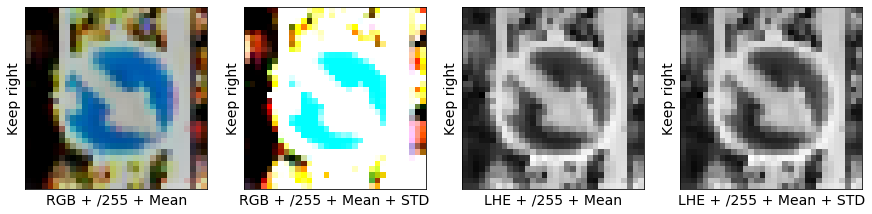

In [40]:
# Retrieving and displaying the same image along with the different tranformations applied. 
# The images from the four datasets are then sent as input to the trained model, and displaying the predicted class label.
k = 1  # Setting index for the plots
ii = 0  # Setting index for getting method's name
import random
#index1=random.randint(1,86988)
#print('index is:',index1)

for i in n:
    # Preparing image for predicting from test dataset
    x_input = data[i]['x_test'][450:451, :, :, :]
    # print(x_input.shape)  # (1, 32, 32, 3) or (1, 32, 32, 1)
    
    y_input = data[i]['y_test'][450:451]
    # print(y_input)  # [3]
    
    # Plotting input image
    plt.subplot(1, 4, k)  # rows, columns, current index of the plot
    if i == 3 or i == 4:
        plt.imshow(x_input[0, :, :, 0], cmap='gray')
    else:
        plt.imshow(x_input[0])
    plt.xlabel(m[ii], fontsize=14)
    plt.ylabel(labels[y_input[0]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    k += 1
    ii += 1
    
    # Getting scores from forward pass of input image
    scores = model[i].predict(x_input)
    # print(scores[0].shape)  # (43,)

    # Scores is given for image with 43 numbers of predictions for each class
    # Getting only one class with maximum value
    prediction = np.argmax(scores)
    print('Predicted classId for model trained on dataset{0}.pickle: {1}'.format(i, prediction))

    # Printing label for classified Traffic Sign
    print('Predicted label:', labels[prediction])
    
    print()


# Showing the plot
plt.show()

In [0]:
#Lets save the models for future experimental purposes.
for i in n:
    name = 'model-dataset' + str(i) + '.h5'
    model[i].save(name)

In [0]:
# Lets load the model for identifying random images from the dataset.
from keras.models import load_model

for i in n:
  l_name = 'model-dataset' + str(i) + '.h5'
  model[i] = load_model(l_name)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted classId for model trained on dataset1.pickle: 7
Predicted label: Speed limit (100km/h)

Predicted classId for model trained on dataset2.pickle: 7
Predicted label: Speed limit (100km/h)

Predicted classId for model trained on dataset3.pickle: 7
Predicted label: Speed limit (100km/h)

Predicted classId for model trained on dataset4.pickle: 7
Predicted label: Speed limit (100km/h)

Predicted class is: Speed limit (100km/h)


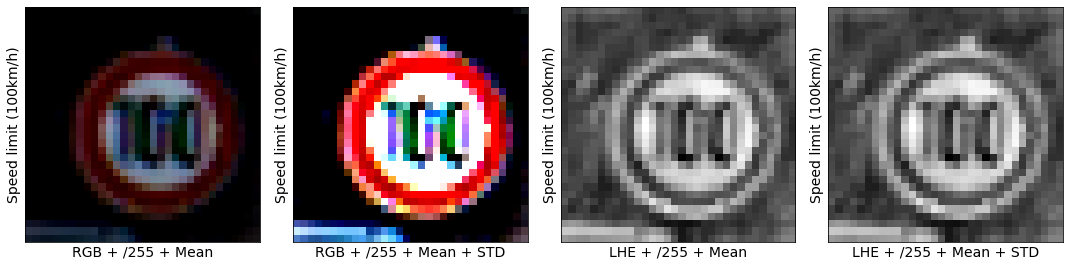

In [46]:
# Now lets use a random image as input for the loaded models, these models can then be used to identify as to which 
# class do the image belong to.
k = 1  # Setting index for the plots
ii = 0  # Setting index for getting method's name
import random
import operator
num1=random.randint(100,5000)
pred1={}
for i in n:
    # Preparing image for predicting from test dataset
    x_input = data[i]['x_test'][num1:num1+1, :, :, :]
    # print(x_input.shape)  # (1, 32, 32, 3) or (1, 32, 32, 1)
    
    y_input = data[i]['y_test'][num1:num1+1]
    # print(y_input)  # [3]
    
    # Plotting input image
    plt.subplot(1, 4, k)  # rows, columns, current index of the plot
    if i == 3 or i == 4:
        plt.imshow(x_input[0, :, :, 0], cmap='gray')
    else:
        plt.imshow(x_input[0])
    plt.xlabel(m[ii], fontsize=14)
    plt.ylabel(labels[y_input[0]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    k += 1
    ii += 1
    
    # Getting scores from forward pass of input image
    scores = model[i].predict(x_input)
    # print('scores are',scores[0])
    # print(scores[0].shape)  # (43,)

    # Scores is given for image with 43 numbers of predictions for each class
    # Getting only one class with maximum value
    prediction = np.argmax(scores)
    # print('prediction class',prediction)
    print('Predicted classId for model trained on dataset{0}.pickle: {1}'.format(i, prediction))

    # Printing label for classified Traffic Sign
    print('Predicted label:', labels[prediction])
    
    if labels[prediction] in pred1:
      pred1[labels[prediction]]+=1
    else:
      pred1[labels[prediction]]=1


    print()

# Print the prediction of the modified images with maximum occurrence. This makes sure that even if a model predicts incorrectly,
# still the maximum correct prediction is displayed
print('Predicted class is:',max(pred1.items(), key=operator.itemgetter(1))[0])

# Adjusting height between subplots
plt.subplots_adjust(hspace=10)
plt.tight_layout()

# Showing the plot
plt.show()

In [0]:
# The image is correctly predicted as denoting a speed limit sign of 100 km/hr despite being distorted 
# and being modified in different ways.
# Even if 3 out of the 4 models depict the correct label, we make sure that the right result is displayed 
# by taking the maximum right labels predicted by the 4 models.